### Investigation into safety cars
In this notebook I want to investigate safety cars. My main question is whether the amount of safety cars can be modelled by using a poisson distribution. In order to do this I need to do the following things

0. Data cleaning.\
    I noticed that there were strange spikes in the laptimes, these can be attributed to pitstops. I will subtract the pitstop time to get more accurate results\
    I also noticed some laps lasting over several minutes. These were then often red-flagged. I will replace them with the avere laptime where needed
1. Find safety cars in the data\
   Hypothesis: A safety car can be found by the following things
        - Increasing laptimes
        - No overtaking
        - Smaller time-difference between first and last driver
        - Smaller time-difference between all drivers
2. Look at their distribution.
    Find Lambda (expected per time interval)
        Investigate lambda, are there differences per track? Or year?
3. Comment on this, was Austria 2020 so strange?
    


In [1]:
## Imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression


# To get full output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#set random seed
random.seed(20)

In [2]:
# Change current working directory to where our F1 data is stored
os.getcwd();
os.chdir('C:\\Users\\yanni\\OneDrive\\Documents\\Data_Science\\F1_data')
os.getcwd()  

'C:\\Users\\yanni\\OneDrive\\Documents\\Data_Science'

'C:\\Users\\yanni\\OneDrive\\Documents\\Data_Science\\F1_data'

We want to have the laptimes per round, so we need the laptimes dataset. 

In [3]:
laptimes_df = pd.read_csv('lap_times.csv')

In [4]:
laptimes_df.head()
laptimes_df.shape
laptimes_df.dtypes
laptimes_df.describe(include = 'all')
laptimes_df['raceId'].nunique()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


(472504, 6)

raceId           int64
driverId         int64
lap              int64
position         int64
time            object
milliseconds     int64
dtype: object

,raceId,driverId,lap,position,time,milliseconds
count,472504.000000,472504.000000,472504.000000,472504.000000,472504,4.725040e+05
unique,NaN,NaN,NaN,NaN,70008,NaN
top,NaN,NaN,NaN,NaN,1:21.571,NaN
freq,NaN,NaN,NaN,NaN,36,NaN
mean,480.078222,229.773778,29.871804,9.651368,NaN,9.555486e+04
std,402.031351,345.382163,18.389696,5.562434,NaN,7.123219e+04
min,1.000000,1.000000,1.000000,1.000000,NaN,6.695700e+04
25%,112.000000,14.000000,14.000000,5.000000,NaN,8.223500e+04
50%,228.000000,30.000000,29.000000,9.000000,NaN,9.088100e+04
75%,911.000000,807.000000,44.000000,14.000000,NaN,1.026610e+05


437

In [5]:
# I also want to know which race I'm looking at, so I'll add that info
races_df = pd.read_csv('races.csv')
races_df.head()
races_df.dtypes
races_df['race'] = races_df['name'] + ' ' + races_df['year'].astype(str)
races_df.head()
races_df['raceId'].nunique()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Grand_Prix
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Grand_Prix
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Grand_Prix
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix


raceId        int64
year          int64
round         int64
circuitId     int64
name         object
date         object
time         object
url          object
dtype: object

,raceId,year,round,circuitId,name,date,time,url,race
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix,Australian Grand Prix 2009
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Grand_Prix,Malaysian Grand Prix 2009
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Grand_Prix,Chinese Grand Prix 2009
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Grand_Prix,Bahrain Grand Prix 2009
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix,Spanish Grand Prix 2009


1040

In [6]:
# Add pitstop data
pitstops_df = pd.read_csv('pit_stops.csv')

In [7]:
pitstops_df.head()
pitstops_df.shape
pitstops_df.dtypes
pitstops_df.describe(include = 'all')
pitstops_df['raceId'].nunique()

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


(7436, 7)

raceId           int64
driverId         int64
stop             int64
lap              int64
time            object
duration        object
milliseconds     int64
dtype: object

,raceId,driverId,stop,lap,time,duration,milliseconds
count,7436.000000,7436.000000,7436.000000,7436.000000,7436,7436,7.436000e+03
unique,NaN,NaN,NaN,NaN,5834,5462,NaN
top,NaN,NaN,NaN,NaN,14:56:46,23.732,NaN
freq,NaN,NaN,NaN,NaN,5,6,NaN
mean,924.202528,460.913932,1.772458,24.975524,NaN,NaN,4.408520e+04
std,55.539396,396.519805,0.918099,14.164959,NaN,NaN,1.645216e+05
min,841.000000,1.000000,1.000000,1.000000,NaN,NaN,1.289700e+04
25%,874.000000,16.000000,1.000000,13.000000,NaN,NaN,2.183875e+04
50%,916.000000,808.000000,2.000000,24.000000,NaN,NaN,2.338300e+04
75%,969.250000,823.250000,2.000000,35.000000,NaN,NaN,2.557650e+04


179

In [8]:
# I notice that there are only 179 races of which I have the pitstop data
# For now I will only include these races in my analysis
pitstop_race_ids = pitstops_df['raceId'].unique()
laptimes_df = laptimes_df[laptimes_df['raceId'].isin(pitstop_race_ids)]
races_df = races_df[races_df['raceId'].isin(pitstop_race_ids)]

print("We now have data of {} races".format(races_df['raceId'].nunique()))

We now have data of 179 races


#### Step 1. Find safetycars in the data
In order to find these in the data we have the following hypotheses
1. There are increasing laptimes
2. There is no overtaking
3. The time difference between the first and the last driver decreases

In [83]:
# Hypothesis 1. There are increasing laptimes
# I first make the table that is needed. THis contains per racer, race and lap the laptime and time without pitstop
laptime_race_df = laptimes_df.merge(races_df[['raceId', 'race']]
                                    , how = 'left'
                                    , on = 'raceId')
laptime_race_df = laptime_race_df.merge(pitstops_df[['raceId', 'driverId', 'lap', 'milliseconds']]
                                , on = ['raceId', 'driverId', 'lap']
                                , how = 'left')\
                                .fillna(0)
laptime_race_df = laptime_race_df.rename(columns = {'milliseconds_x' : 'laptime_ms'
                                 , 'milliseconds_y' : 'pitstop_ms'}
laptime_race_df['laptime_without_pit_ms'] = laptime_race_df['laptime_ms'] - laptime_race_df['pitstop_ms']
laptime_race_df.head(100)

,raceId,driverId,lap,position,time,laptime_ms,race,pitstop_ms,laptime_without_pit_ms
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011,0.0,98109.0
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011,0.0,93006.0
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011,0.0,92713.0
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011,0.0,92803.0
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011,0.0,92342.0
5,841,20,6,1,1:32.605,92605,Australian Grand Prix 2011,0.0,92605.0
6,841,20,7,1,1:32.502,92502,Australian Grand Prix 2011,0.0,92502.0
7,841,20,8,1,1:32.537,92537,Australian Grand Prix 2011,0.0,92537.0
8,841,20,9,1,1:33.240,93240,Australian Grand Prix 2011,0.0,93240.0
9,841,20,10,1,1:32.572,92572,Australian Grand Prix 2011,0.0,92572.0


In [84]:
# Here I'll get the mean time per lap
# This is both for the laptimes and the laptimes without pitstops
avg_laptimes_race_df = laptime_race_df[['raceId', 'lap', 'race','laptime_ms', 'laptime_without_pit_ms']]\
                                     .groupby(['raceId', 'lap'])\
                                     .agg({'laptime_ms' : 'mean'
                                           , 'laptime_without_pit_ms' : 'mean'
                                           , 'race'         : 'max'})
avg_laptimes_race_df = avg_laptimes_race_df.reset_index()
avg_laptimes_race_df.head()

,raceId,lap,laptime_ms,laptime_without_pit_ms,race
0,841,1,112015.090909,109655.136364,Australian Grand Prix 2011
1,841,2,96863.363636,96863.363636,Australian Grand Prix 2011
2,841,3,95564.954545,95564.954545,Australian Grand Prix 2011
3,841,4,95148.636364,95148.636364,Australian Grand Prix 2011
4,841,5,95357.500000,95357.500000,Australian Grand Prix 2011


Text(0.5, 1.0, 'average laptimes of Chinese Grand Prix 2019')

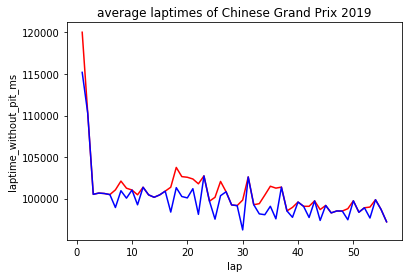

In [85]:
# Visualize the laptimes of an individual race
# Here we select a race to visualize
plot_raceID = random.choice(np.unique(avg_laptimes_race_df['raceId']))

# sns.regplot(x = 'lap'
#             , y = 'laptime_ms'
#             , data = avg_laptimes_race_df[avg_laptimes_race_df['raceId'] == plot_raceID]
#             , scatter = False
#             , line_kws={'color' : 'red',
#                        'ls' : '--'}
#            )
# sns.regplot(x = 'lap'
#             , y = 'laptime_without_pit_ms'
#             , data = avg_laptimes_race_df[avg_laptimes_race_df['raceId'] == plot_raceID]
#             , scatter = False
#             , line_kws={'color' : 'blue',
#                        'ls' : '--'}
#            )
sns.lineplot(x = 'lap'
            , y = 'laptime_ms'
            , data = avg_laptimes_race_df[avg_laptimes_race_df['raceId'] == plot_raceID]
            , color = 'red')\
.set_title("average laptimes of {}".format(avg_laptimes_race_df['race'][avg_laptimes_race_df['raceId'] == plot_raceID].iloc[0]))


sns.lineplot(x = 'lap'
            , y = 'laptime_without_pit_ms'
            , data = avg_laptimes_race_df[avg_laptimes_race_df['raceId'] == plot_raceID]
            , color = 'blue')

In [86]:
# From this plot we can see that most of the times the laptimes
# should be going down
# we will check with a regression whether that is indeed the case
# Here X will be the lapnumber, and Y will be the laptime
for variable in ['laptime_ms', 'laptime_without_pit_ms']:
    X = avg_laptimes_race_df[['lap']]
    y = avg_laptimes_race_df[[variable]]
    reg = LinearRegression().fit(X, y)
    print('Every lap is on average {0:.2f}ms faster than the previous, using {1}'.format(reg.coef_[0][0], variable))

Every lap is on average -327.42ms faster than the previous, using laptime_ms
Every lap is on average -282.12ms faster than the previous, using laptime_without_pit_ms


### Z-score
Our first hypothesis is that laps are way slower when there is a safety car. In order to find these laps we will use the z-score. We will say if there is a z-score higher than 1 that it is a slower round.

We will use the laptimes without the pitstops for the remainder of the analysis and creation of our indicators. Furthermore we saw that there are sessions with red flags. These laps then have a time of several minutes. In order to clean this I will replace them with the value of the round before

In [118]:
# Replace laptime_witout_pit_ms with a cleaned version for when there is a red flag
# I will do this by changing for the mean when a lap is over 3 times the average time of a lap
# This value is arbirarily chosen


# CONTINUE HERE

KeyError: 'raceId'

In [87]:
# We use the z-score
def zscore(s):
    return (s - np.mean(s)) / np.std(s)

In [88]:
avg_laptimes_race_df.head()
z_score_laptime_df = avg_laptimes_race_df[['raceId', 'lap', 'laptime_without_pit_ms']]\
                            .groupby(['raceId'])\
                            .apply(lambda x : zscore(x).gt(1))\
                            .rename(columns = {'laptime_without_pit_ms' : '1std_difference_ms'})

z_score_laptime_df.head()
avg_laptimes_race_df = avg_laptimes_race_df.merge(z_score_laptime_df
                       , how = 'left'
                       , left_index = True
                       , right_index = True
                       )\
.drop(['raceId_y', 'lap_y'], axis = 'columns')\
.rename(columns = {'raceId_x' : 'raceId'
                   , 'lap_x': 'lap'})
avg_laptimes_race_df.head(150)

,raceId,lap,laptime_ms,laptime_without_pit_ms,race
0,841,1,112015.090909,109655.136364,Australian Grand Prix 2011
1,841,2,96863.363636,96863.363636,Australian Grand Prix 2011
2,841,3,95564.954545,95564.954545,Australian Grand Prix 2011
3,841,4,95148.636364,95148.636364,Australian Grand Prix 2011
4,841,5,95357.500000,95357.500000,Australian Grand Prix 2011


,raceId,lap,1std_difference_ms
0,False,False,True
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


,raceId,lap,laptime_ms,laptime_without_pit_ms,race,1std_difference_ms
0,841,1,112015.090909,109655.136364,Australian Grand Prix 2011,True
1,841,2,96863.363636,96863.363636,Australian Grand Prix 2011,False
2,841,3,95564.954545,95564.954545,Australian Grand Prix 2011,False
3,841,4,95148.636364,95148.636364,Australian Grand Prix 2011,False
4,841,5,95357.500000,95357.500000,Australian Grand Prix 2011,False
5,841,6,94870.500000,94870.500000,Australian Grand Prix 2011,False
6,841,7,95187.818182,95187.818182,Australian Grand Prix 2011,False
7,841,8,95061.363636,95061.363636,Australian Grand Prix 2011,False
8,841,9,95116.318182,95116.318182,Australian Grand Prix 2011,False
9,841,10,95130.714286,95130.714286,Australian Grand Prix 2011,False


In [89]:
# Thus, we can see that the laptime should be going down with each lap
# Based on this info we can see that someting is going on if this is not the case
# We will make an indicator for this, indicating whether the lap was faster than the previous

# Later on we saw that we get noise due to small differences. However, under a safetycar there should be larger differences in time
# Therefore we set a difference of 5%
avg_laptimes_race_df['previous_round'] = avg_laptimes_race_df.groupby('raceId')['laptime_without_pit_ms'].shift()

avg_laptimes_race_df['slower_previous'] = np.where(avg_laptimes_race_df['laptime_without_pit_ms'] > 1.05 * avg_laptimes_race_df['previous_round']
                                                   , True
                                                   , False)
avg_laptimes_race_df.head(100)

,raceId,lap,laptime_ms,laptime_without_pit_ms,race,1std_difference_ms,previous_round,slower_previous
0,841,1,112015.090909,109655.136364,Australian Grand Prix 2011,True,NaN,False
1,841,2,96863.363636,96863.363636,Australian Grand Prix 2011,False,109655.136364,False
2,841,3,95564.954545,95564.954545,Australian Grand Prix 2011,False,96863.363636,False
3,841,4,95148.636364,95148.636364,Australian Grand Prix 2011,False,95564.954545,False
4,841,5,95357.500000,95357.500000,Australian Grand Prix 2011,False,95148.636364,False
5,841,6,94870.500000,94870.500000,Australian Grand Prix 2011,False,95357.500000,False
6,841,7,95187.818182,95187.818182,Australian Grand Prix 2011,False,94870.500000,False
7,841,8,95061.363636,95061.363636,Australian Grand Prix 2011,False,95187.818182,False
8,841,9,95116.318182,95116.318182,Australian Grand Prix 2011,False,95061.363636,False
9,841,10,95130.714286,95130.714286,Australian Grand Prix 2011,False,95116.318182,False


We now have an indicator to show whether this lap was faster than the previous lap. However, there are multiple reasons why a lap can be slower. Such as: pit-stops, rain, traffic etc.
Therefore we want to have more conditions, and we will continue with our next hypothesis:
There will be no overtaking during a safety-car

#### How to find this
We can find this by taking a look at the position of a driver during the race, and comparing it to the round before. If it's the same then the driver was not overtaken or did not overtake.

Text(0.5, 1.0, 'Changes in position during Australian Grand Prix 2011')

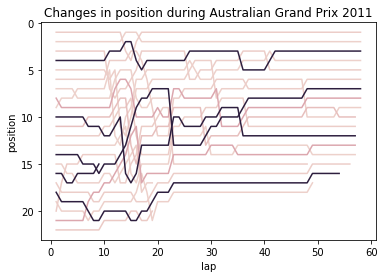

In [90]:
# First we will take a look at the position of drivers during a race
ax = sns.lineplot(x = 'lap', y = 'position', hue = 'driverId', data = laptime_race_df[(laptime_race_df['raceId'] == 841)])
ax.set_title("Changes in position during {}".format(laptime_race_df['race'][laptime_race_df['raceId'] == 841].iloc[0]))
ax.invert_yaxis()
ax.legend_.remove()

In [91]:
# From here we can see that there are some times when there are many changes (pit-stops)
# We will now make an indicator to see if someone was overtaken
laptime_race_df.head()
laptime_race_df['position_previous_round'] = laptime_race_df.groupby(['raceId', 'driverId'])['position'].shift()
laptime_race_df['overtake'] = np.where(laptime_race_df['position'] < laptime_race_df['position_previous_round']
                                       , True
                                       , False)  
laptime_race_df.head(100)


,raceId,driverId,lap,position,time,laptime_ms,race,pitstop_ms,laptime_without_pit_ms
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011,0.0,98109.0
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011,0.0,93006.0
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011,0.0,92713.0
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011,0.0,92803.0
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011,0.0,92342.0


,raceId,driverId,lap,position,time,laptime_ms,race,pitstop_ms,laptime_without_pit_ms,position_previous_round,overtake
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011,0.0,98109.0,NaN,False
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011,0.0,93006.0,1.0,False
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011,0.0,92713.0,1.0,False
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011,0.0,92803.0,1.0,False
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011,0.0,92342.0,1.0,False
5,841,20,6,1,1:32.605,92605,Australian Grand Prix 2011,0.0,92605.0,1.0,False
6,841,20,7,1,1:32.502,92502,Australian Grand Prix 2011,0.0,92502.0,1.0,False
7,841,20,8,1,1:32.537,92537,Australian Grand Prix 2011,0.0,92537.0,1.0,False
8,841,20,9,1,1:33.240,93240,Australian Grand Prix 2011,0.0,93240.0,1.0,False
9,841,20,10,1,1:32.572,92572,Australian Grand Prix 2011,0.0,92572.0,1.0,False


In [92]:
# We now have an indicator per driver if they did an overtake.
# However, we want to know per lap of the race if there was an overtake
overtake_df = laptime_race_df[['raceId', 'lap','overtake',]]\
                                     .groupby(['raceId', 'lap'])\
                                     .max()\
                                     .reset_index() 

overtake_df.head(100)

,raceId,lap,overtake
0,841,1,False
1,841,2,True
2,841,3,True
3,841,4,False
4,841,5,True
5,841,6,True
6,841,7,True
7,841,8,True
8,841,9,True
9,841,10,True


0      1
3      4
21    22
23    24
32    33
33    34
37    38
38    39
39    40
42    43
43    44
44    45
45    46
46    47
49    50
50    51
51    52
52    53
54    55
55    56
56    57
57    58
Name: lap, dtype: int64

Text(0.5, 1.0, 'Changes in position during Australian Grand Prix 2011')

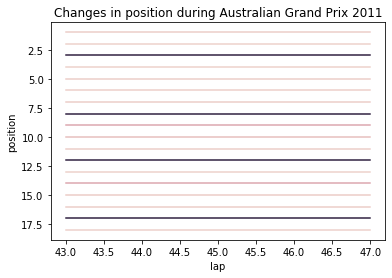

In [93]:
# To check if this works the way we want to we check the results with the graph
overtake_df['lap'][(overtake_df['overtake'] == False) & (overtake_df['raceId'] == 841)]

# It seems there were no overtakes in lap 43 to 47
no_overtake_laps_df = laptime_race_df[(laptime_race_df['lap'] >= 43) 
                                   & (laptime_race_df['lap'] <= 47) 
                                   & (laptime_race_df['raceId'] == 841)]

ax = sns.lineplot(x = 'lap', y = 'position', hue = 'driverId', data = no_overtake_laps_df)
ax.set_title("Changes in position during {}".format(laptime_race_df['race'][laptime_race_df['raceId'] == 841].iloc[0]))
ax.invert_yaxis()
ax.legend_.remove()

# We only see straight lines so indeed no overtakes
# I checked and there was no safety car during this period

In [94]:
# We join this to our initial df
avg_laptimes_race_df = avg_laptimes_race_df.merge(overtake_df[['raceId'
                                                               , 'lap'
                                                               , 'overtake']]
                                    , how = 'left'
                                    , on = ['raceId', 'lap'])
avg_laptimes_race_df.head()

,raceId,lap,laptime_ms,laptime_without_pit_ms,race,1std_difference_ms,previous_round,slower_previous,overtake
0,841,1,112015.090909,109655.136364,Australian Grand Prix 2011,True,NaN,False,False
1,841,2,96863.363636,96863.363636,Australian Grand Prix 2011,False,109655.136364,False,True
2,841,3,95564.954545,95564.954545,Australian Grand Prix 2011,False,96863.363636,False,True
3,841,4,95148.636364,95148.636364,Australian Grand Prix 2011,False,95564.954545,False,False
4,841,5,95357.500000,95357.500000,Australian Grand Prix 2011,False,95148.636364,False,True


We now have our second indicator finished, whether there was overtaking. We will continue with working on our next indicator. There will be a decrease in time between the first and last driver.

In order to do this I want to create a cumulative sum of the laptimes per driver per race
This can then be used to calculate the difference to the driver in first position

In [95]:
# we will use laptime_race_df again
laptime_race_df.head()

,raceId,driverId,lap,position,time,laptime_ms,race,pitstop_ms,laptime_without_pit_ms,position_previous_round,overtake
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011,0.0,98109.0,NaN,False
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011,0.0,93006.0,1.0,False
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011,0.0,92713.0,1.0,False
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011,0.0,92803.0,1.0,False
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011,0.0,92342.0,1.0,False


In [96]:
laptime_race_df = laptime_race_df.merge(laptime_race_df[['raceId', 'driverId', 'lap', 'laptime_without_pit_ms']]\
                            .groupby(by = ['raceId', 'driverId', 'lap']) \
                            .sum() \
                            .groupby(level = [0,1]) \
                            .cumsum() \
                            .reset_index()
                            .rename(columns = {'laptime_without_pit_ms' : 'cumulative_time'})
                        , how = 'left'
                        , on = ['raceId', 'driverId', 'lap']
                       ) 
           
laptime_race_df.head()

,raceId,driverId,lap,position,time,laptime_ms,race,pitstop_ms,laptime_without_pit_ms,position_previous_round,overtake,cumulative_time
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011,0.0,98109.0,NaN,False,98109.0
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011,0.0,93006.0,1.0,False,191115.0
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011,0.0,92713.0,1.0,False,283828.0
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011,0.0,92803.0,1.0,False,376631.0
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011,0.0,92342.0,1.0,False,468973.0


In [97]:
laptime_race_df = laptime_race_df.merge(laptime_race_df[['raceId', 'lap', 'position', 'driverId', 'cumulative_time']]\
                            .sort_values(['raceId'
                                            , 'lap'
                                            , 'position']
                                        , ascending = True)\
                            .set_index(['raceId', 'lap', 'driverId'])\
                            .groupby(['raceId', 'lap']) \
                            .diff() \
                            .groupby(['raceId', 'lap']) \
                            .cumsum() \
                            .fillna(0) \
                            .reset_index() \
                            .rename(columns = {'cumulative_time' : 'ms_difference_P1'})
                        , how = 'left'
                        , on = ['raceId', 'driverId', 'lap']
                       )\
                .drop('position_y', axis = 'columns') \
                .rename(columns = {'position_x' : 'position'})


laptime_race_df.sort_values(['raceId'
                , 'lap'
                , 'position']
                , ascending = True).head(5)


,raceId,driverId,lap,position,time,laptime_ms,race,pitstop_ms,laptime_without_pit_ms,position_previous_round,overtake,cumulative_time,ms_difference_P1
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011,0.0,98109.0,NaN,False,98109.0,0.0
58,841,1,1,2,1:40.573,100573,Australian Grand Prix 2011,0.0,100573.0,NaN,False,100573.0,2464.0
116,841,17,1,3,1:41.467,101467,Australian Grand Prix 2011,0.0,101467.0,NaN,False,101467.0,3358.0
174,841,808,1,4,1:42.835,102835,Australian Grand Prix 2011,0.0,102835.0,NaN,False,102835.0,4726.0
232,841,13,1,5,1:44.196,104196,Australian Grand Prix 2011,0.0,104196.0,NaN,False,104196.0,6087.0


Text(0.5, 1.0, 'Changes in position during Australian Grand Prix 2011')

,raceId,driverId,lap,position,time,laptime_ms,race,pitstop_ms,laptime_without_pit_ms,position_previous_round,overtake,cumulative_time,ms_difference_P1
713,841,2,57,14,1:35.088,95088,Australian Grand Prix 2011,0.0,95088.0,14.0,False,5395809.0,164135.0
57,841,20,58,1,1:31.946,91946,Australian Grand Prix 2011,0.0,91946.0,1.0,False,5323620.0,0.0
115,841,1,58,2,1:34.576,94576,Australian Grand Prix 2011,0.0,94576.0,2.0,False,5346130.0,22510.0
231,841,808,58,3,1:30.767,90767,Australian Grand Prix 2011,0.0,90767.0,3.0,False,5350601.0,26981.0
485,841,4,58,4,1:30.501,90501,Australian Grand Prix 2011,0.0,90501.0,4.0,False,5329866.0,6246.0
173,841,17,58,5,1:32.279,92279,Australian Grand Prix 2011,0.0,92279.0,5.0,False,5336254.0,12634.0
347,841,18,58,6,1:31.203,91203,Australian Grand Prix 2011,0.0,91203.0,6.0,False,5361712.0,38092.0
771,841,815,58,7,1:32.577,92577,Australian Grand Prix 2011,0.0,92577.0,7.0,False,5412666.0,89046.0
427,841,155,58,8,1:31.830,91830,Australian Grand Prix 2011,0.0,91830.0,8.0,False,5398875.0,75255.0
289,841,13,58,9,1:31.822,91822,Australian Grand Prix 2011,0.0,91822.0,9.0,False,5383008.0,59388.0


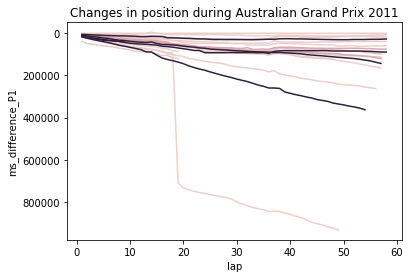

In [98]:
#  We seem to have a working solution
#  We will now try to visualize to understand if all is going how it should go
test_df = laptime_race_df[laptime_race_df['raceId'] == 841]
# It seems to work
ax = sns.lineplot(x = 'lap', y = 'ms_difference_P1', hue = 'driverId', data = test_df)
ax.set_title("Changes in position during {}".format(laptime_race_df['race'][laptime_race_df['raceId'] == 841].iloc[0]))
ax.invert_yaxis()
ax.legend_.remove()

test_df.sort_values(by = ['lap', 'position']).tail(10)
# We also checked the results of this race online. It all works the way it should

Now that we now the difference between the drivers we want to know whether the times decrease between the P1 driver and the last driver, and whether the total time of between drivers decrease. We can reuse our earlier code to check if that is the case

In [99]:
# Check whether the time between the first and last driver decreases
grouped_differences_df = laptime_race_df[['raceId', 'lap','ms_difference_P1',]]\
                                         .groupby(['raceId', 'lap'])\
                                         .agg(
                                                ms_difference_sum = ('ms_difference_P1', 'sum')
                                              , ms_difference_max = ('ms_difference_P1', 'max')
                                             )\
                                         .reset_index()


grouped_differences_df['previous_round_sum'] = grouped_differences_df.groupby('raceId')['ms_difference_sum'].shift()
grouped_differences_df['previous_round_max'] = grouped_differences_df.groupby('raceId')['ms_difference_max'].shift()


grouped_differences_df['smaller_previous_sum'] = np.where(grouped_differences_df['ms_difference_sum'] 
                                                        < grouped_differences_df['previous_round_sum']
                                                       , True
                                                       , False)
grouped_differences_df['smaller_previous_max'] = np.where(grouped_differences_df['ms_difference_max'] 
                                                        < grouped_differences_df['previous_round_max']
                                                       , True
                                                       , False)

grouped_differences_df.head(100)

,raceId,lap,ms_difference_sum,ms_difference_max,previous_round_sum,previous_round_max,smaller_previous_sum,smaller_previous_max
0,841,1,254015.0,38298.0,NaN,NaN,False,False
1,841,2,338877.0,48319.0,254015.0,38298.0,False,False
2,841,3,401620.0,52208.0,338877.0,48319.0,False,False
3,841,4,453224.0,55467.0,401620.0,52208.0,False,False
4,841,5,519565.0,58964.0,453224.0,55467.0,False,False
5,841,6,569406.0,61940.0,519565.0,58964.0,False,False
6,841,7,628494.0,65232.0,569406.0,61940.0,False,False
7,841,8,684030.0,70377.0,628494.0,65232.0,False,False
8,841,9,725309.0,73901.0,684030.0,70377.0,False,False
9,841,10,736963.0,79845.0,725309.0,73901.0,False,False


In [100]:
avg_laptimes_race_df.head()
avg_laptimes_race_df = avg_laptimes_race_df.merge(grouped_differences_df[['raceId', 'lap', 'smaller_previous_sum', 'smaller_previous_max']]
, how = 'left'
, on = ['raceId', 'lap'])

avg_laptimes_race_df.head()

,raceId,lap,laptime_ms,laptime_without_pit_ms,race,1std_difference_ms,previous_round,slower_previous,overtake
0,841,1,112015.090909,109655.136364,Australian Grand Prix 2011,True,NaN,False,False
1,841,2,96863.363636,96863.363636,Australian Grand Prix 2011,False,109655.136364,False,True
2,841,3,95564.954545,95564.954545,Australian Grand Prix 2011,False,96863.363636,False,True
3,841,4,95148.636364,95148.636364,Australian Grand Prix 2011,False,95564.954545,False,False
4,841,5,95357.500000,95357.500000,Australian Grand Prix 2011,False,95148.636364,False,True


,raceId,lap,laptime_ms,laptime_without_pit_ms,race,1std_difference_ms,previous_round,slower_previous,overtake,smaller_previous_sum,smaller_previous_max
0,841,1,112015.090909,109655.136364,Australian Grand Prix 2011,True,NaN,False,False,False,False
1,841,2,96863.363636,96863.363636,Australian Grand Prix 2011,False,109655.136364,False,True,False,False
2,841,3,95564.954545,95564.954545,Australian Grand Prix 2011,False,96863.363636,False,True,False,False
3,841,4,95148.636364,95148.636364,Australian Grand Prix 2011,False,95564.954545,False,False,False,False
4,841,5,95357.500000,95357.500000,Australian Grand Prix 2011,False,95148.636364,False,True,False,False


#### Selecting Safety cars
We now have all our indicators that we think are needed to get an overview of find laps with a safety car in the race. 

We think that there is a safety car in a lap when:
- The current lap is **slower** than the previous lap (*faster_previous = False*)
- There is **no** overtaking (*overtake = False*)
- The total difference between drivers gets **smaller** (*faster_previous_sum = True*)
- The maximum difference between drivers gets **smaller** (*faster_previous_max = True*)

In [101]:
avg_laptimes_race_df['safetycar_in_lap'] = np.where(
    (avg_laptimes_race_df['slower_previous'] == True)
    & (avg_laptimes_race_df['overtake'] == False)
    & (avg_laptimes_race_df['smaller_previous_sum'] == True)
    & (avg_laptimes_race_df['smaller_previous_max'] == True)
                                                       , True
                                                       , False)

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'average laptimes of Australian Grand Prix 2011')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'average laptimes of Malaysian Grand Prix 2011')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'average laptimes of Chinese Grand Prix 2011')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'average laptimes of Turkish Grand Prix 2011')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'average laptimes of Spanish Grand Prix 2011')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'average laptimes of Monaco Grand Prix 2011')

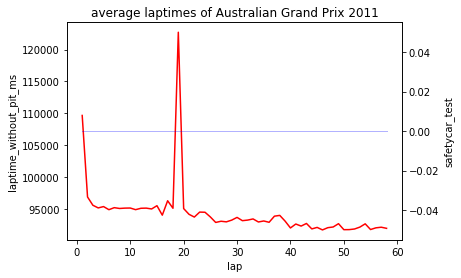

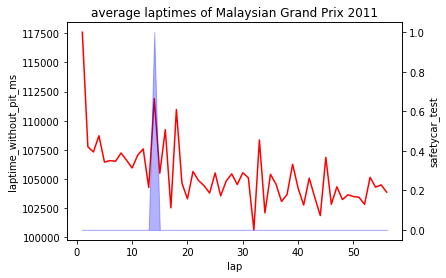

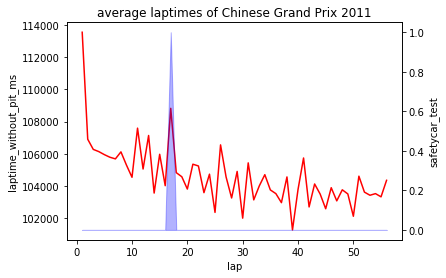

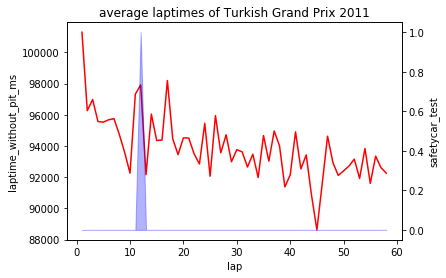

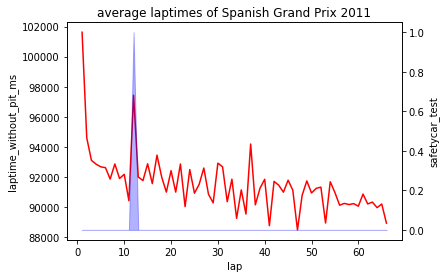

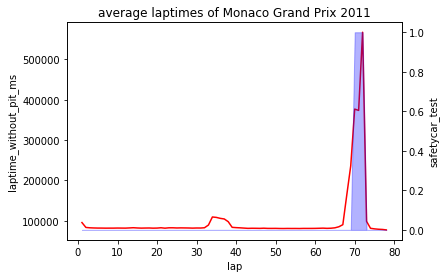

In [106]:
# Let's do a test if we can find safetycars with our current options
avg_laptimes_race_df['safetycar_test'] = np.where(
    (avg_laptimes_race_df['1std_difference_ms'] == True)
#     & (avg_laptimes_race_df['slower_previous'] == True)
#     & (avg_laptimes_race_df['overtake'] == False)
#     & (avg_laptimes_race_df['smaller_previous_sum'] == True)
    & (avg_laptimes_race_df['smaller_previous_max'] == True)
                                                       , True
                                                       , False)

for i in [841,842,843,844, 845, 846]:
    plot_raceID = i
    plt.figure()
    g = sns.lineplot(x = 'lap'
                , y = 'laptime_without_pit_ms'
                , data = avg_laptimes_race_df[avg_laptimes_race_df['raceId'] == plot_raceID]
                , color = 'red')

    ax2 = plt.twinx()
    g = sns.lineplot(x = 'lap'
                , y = 'safetycar_test'
                , data = avg_laptimes_race_df[avg_laptimes_race_df['raceId'] == plot_raceID]
                , ax = ax2
                , alpha = 0
               )

    l1 = g.lines[0]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]

    plt.fill_between(x1,y1, color="blue", alpha=0.3)
    g.set_title("average laptimes of {}".format(avg_laptimes_race_df['race'][avg_laptimes_race_df['raceId'] == plot_raceID].iloc[0]))


In [ ]:
# # Counting of Safety cars
# test_df['N_safetycar'] = test_df.groupby('race')\
# .apply(lambda x: x['1std_difference_ms'].diff().ne(0).cumsum()).reset_index(level = 0, drop = True)

# test_df.loc[test_df['1std_difference_ms'] == 0, 'N_safetycar'] = 0

# test_df[test_df['raceId'] == 3]